[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nepslor/B5203E-TSAF/blob/main/W4/fourier_forecasts_and_regression_pt2_solutions.ipynb)

# Fourier decomposition and forecasting
Under stationarity assumption, Fourier decomposition can be used to extrapolate a signal beyond observed values. In this lesson you'll write a simple Fourier forecaster from scratch. Let's start downloading some time series


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

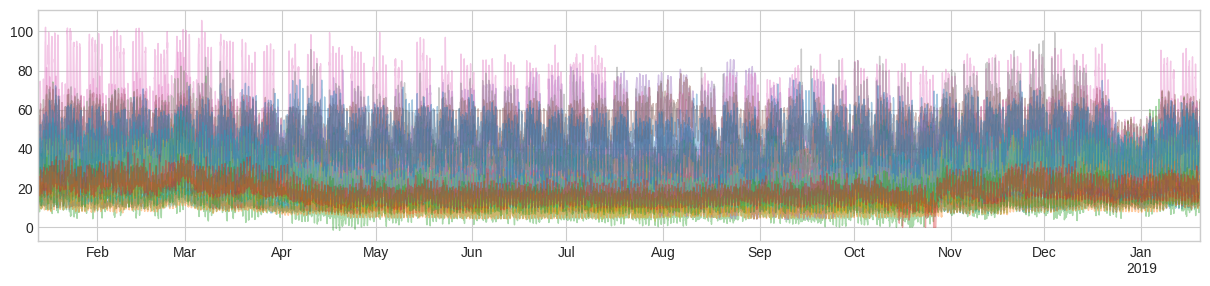

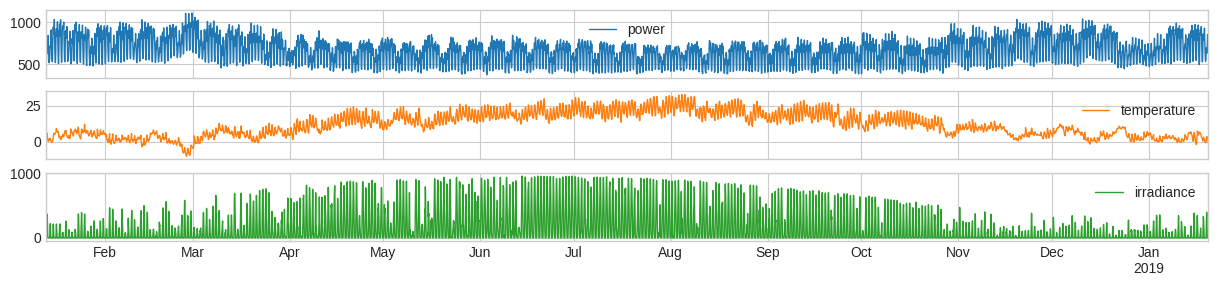

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_power = pd.read_pickle('https://github.com/nepslor/teaching/raw/refs/heads/main/TimeSeriesForecasting/data/power_dataset.pk')

plt.style.use("seaborn-v0_8-whitegrid")
df_power.filter(like='meter').plot(alpha=0.4, linewidth=1, legend=False, figsize=(15, 3))
df_power[['power', 'temperature', 'irradiance']].plot(linewidth=1, subplots=True, figsize=(15, 3))


## ❓ Generate the basis functions
Complete the following code that creates the first $n_h$ basis functions defined as:
$$P = \left[sin\left(\frac{2\pi tk}{l}\right), cos\left(\frac{2\pi tk}{l}\right)\right] \quad k\in \{1,\dots n_h\}$$
where $l$ is the length of $t \in \mathbb{N}^l$.

We then see that the cross-covariance matrix of these basis functions is normal, that is, off-diagonal elements are 0.

Remember that we have to normalize the signals to obtain ortho-**normal** basis. When we integrated the trigonometric functions over 2$\pi$, we shown tha the normalization constant was $\sqrt{\pi}$. Since we're now integrating over $l$, the normalization constant in this case is $\sqrt{l/2}$, that is the square root of half of the integration period:
$$ P_n = \sqrt{2/l} \left[sin\left(\frac{2\pi tk}{l}\right), cos\left(\frac{2\pi tk}{l}\right)\right] \quad k\in \{1,\dots n_h\}$$

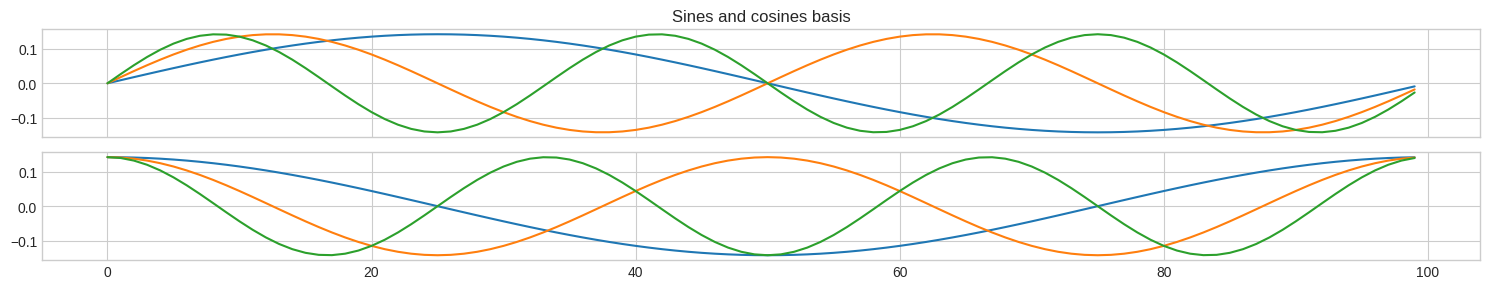

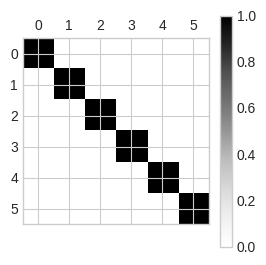

In [2]:

l=100               # lenght of the signal
n_h = 3             # number of harmonics to plot
t = np.arange(l)    # time vector

def get_basis(t, l, n_h):
  """
  Get the first n_h sine and cosine basis functions and the projection
  matrix P
  """
  sines = np.vstack([np.sin(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  cosines = np.vstack([np.cos(2*np.pi*k*t/l) for k in np.arange(n_h)+1])
  P = np.vstack([sines, cosines]).T * np.sqrt(2 / l)
  return P

P = get_basis(t, l, n_h)
sines, cosines = P[:, :n_h].T, P[:, n_h:].T

fig, ax = plt.subplots(2, 1, figsize=(15, 3), layout="tight")
ax[0].plot(sines.T)
ax[0].set_xticklabels([])
ax[1].plot(cosines.T)
ax[0].set_title('Sines and cosines basis')

fig, ax = plt.subplots(figsize=(3, 3))
m = ax.matshow(P.T@P)
plt.colorbar(m)



The following is just an utility function to remove the mean from the power signal and return a training and a test set.

In [3]:
def get_tr_te(p, training_steps, steps_ahead):
  x_tr = p.iloc[:training_steps].values
  tr_mean = np.mean(x_tr)
  x_tr -= tr_mean
  x_te = p.iloc[training_steps:training_steps+steps_ahead].values
  x_te -= tr_mean
  return x_tr, x_te

steps_ahead = 24*14
training_steps = 24*7

x_tr, x_te = get_tr_te(df_power['power'], training_steps, steps_ahead)

# ❓ Write a Fourier forecaster
Once you have created the basis function with the same length of the training signal, you have to project the original signal onto the basis. Since the basis matrix is orthonormal:
$$\beta = (P^TP)^{-1}(P^Tx) =I(P^Tx)=
 P^Tx$$

In order to extrapolate you just have to create a longer basis matrix $P$ and obtain the extrapolated signal using $\beta$.

You can reuse the `get_basis` function to define a new matrix, $P_{fore}$, defined over $l + l_{fore}$ where $l_{fore}$ is the length of the step ahead to be forecasted.



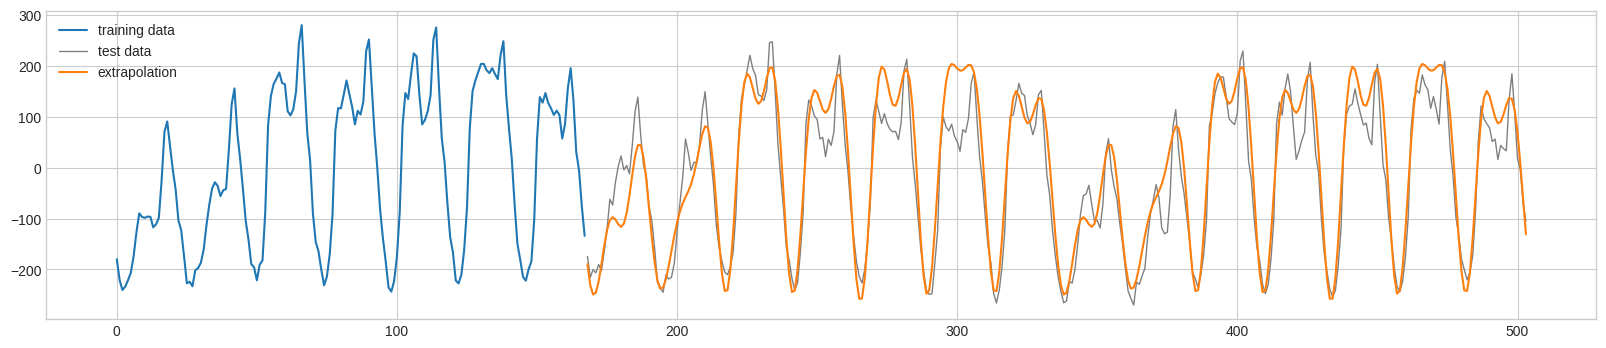

In [4]:
l_tr=len(x_tr)
l_te=len(x_te)
t_tr = np.arange(l_tr)
t_te = np.arange(l_tr, l_tr+l_te)
n_harmonics = 20

# ------------- Fourier decomposition - linear regression fit -----------------
P = get_basis(t_tr, l_tr, n_harmonics)

# since the basis is orthonormal the following is equivalent to the standard linear regression solution
coeffs = P.T@x_tr

# ------------- Extrapolation - we fix the frequencies and retrieve longer basis

P_pred = get_basis(t_te, l_tr, n_harmonics) # l is the fundamental period, must stay fixed



plt.subplots(1, 1, figsize=(20, 4))
plt.plot(x_tr, label='training data')
plt.plot(np.hstack([x_tr*np.nan, x_te]), color='grey', linewidth=1, label='test data')
plt.plot(t_te, P_pred@coeffs, label='extrapolation')
plt.legend();

# ❓ What's the optimal $n_h$?
Write a function to get the MAE on the test set, then write an optimizer to obtain the optimal value of $n_h$


our method explored 128 solutions in 0.39374470710754395s


/tmp/ipykernel_6381/4973678.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


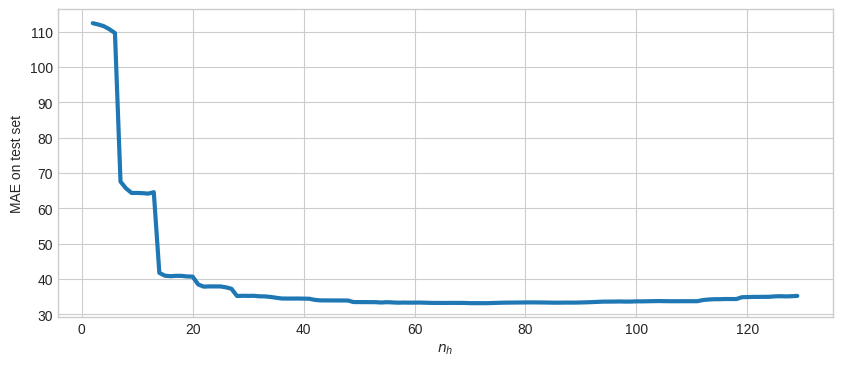

In [5]:
from time import time
n_harmonics = np.arange(2, 130)
mae= np.zeros(len(n_harmonics))
mae_fun = lambda err: np.mean(np.abs(err))

t0=time()
for i, n_h in enumerate(n_harmonics):
  P = get_basis(t_tr, l_tr, n_h)
  coeffs = P.T@x_tr
  P_pred = get_basis(t_te, l_tr, n_h)
  x_hat_1 = P_pred@coeffs
  mae[i] = mae_fun(x_hat_1-x_te)
print('our method explored {} solutions in {}s'.format(len(n_harmonics), time()-t0))

plt.subplots(1, 1, figsize=(10, 4))
plt.plot(n_harmonics, np.array(mae), linewidth=3)
plt.ylabel('MAE on test set')
plt.xlabel('$n_h$')
plt.legend();

# Fourier forecaster via Nixtla
The Nixtlaverse is composed by our open-source libraries, designed to provide a comprehensive, cutting-edge toolkit for time series forecasting in python.

In the following we'll see how a similar Fourier forecaster can be written using Nixtla


In [6]:
%%capture
!pip install mlforecast
!pip install utilsforecast
from utilsforecast.feature_engineering import trend, fourier, pipeline
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from utilsforecast.feature_engineering import fourier, pipeline
from functools import partial
from utilsforecast.plotting import plot_series

The first step is to convert our timeseries in a nixtla-compatible format: we need an `unique_id` column with a tag for the name of the timeseries, a 'ds' timestamp and the 'y' containing the actual values:

| unique_id | ds         | y         |
|-----------|------------|-----------|
| id_00     | 2000-01-01 | 17.519167 |
| id_00     | 2000-01-02 | 87.799695 |
| id_00     | 2000-01-03 | 177.442975|
| id_00     | 2000-01-04 | 232.704110|
| id_00     | 2000-01-05 | 317.510474|

In [7]:
def convert_to_nixtla_ts(series):
  """
  Transform a pandas series to a nixtla-compatible df
  """
  name = series.name
  series = series.reset_index(name='y')
  df = pd.DataFrame(series.rename(columns={'index': 'ds'}))
  df['unique_id'] = name
  return df

print('#'*40)
print('original series')
print('#'*40)

print(df_power['power'].head())

df_nixtla = convert_to_nixtla_ts(df_power['power'])
print('#'*40)
print('nixtla compatible df')
print('#'*40)

print(df_nixtla.head())


########################################
original series
########################################
2018-01-13 00:00:00+00:00   -179.922394
2018-01-13 01:00:00+00:00   -220.849827
2018-01-13 02:00:00+00:00   -240.195549
2018-01-13 03:00:00+00:00   -233.736994
2018-01-13 04:00:00+00:00   -221.069105
Freq: h, Name: power, dtype: float64
########################################
nixtla compatible df
########################################
                         ds           y unique_id
0 2018-01-13 00:00:00+00:00 -179.922394     power
1 2018-01-13 01:00:00+00:00 -220.849827     power
2 2018-01-13 02:00:00+00:00 -240.195549     power
3 2018-01-13 03:00:00+00:00 -233.736994     power
4 2018-01-13 04:00:00+00:00 -221.069105     power


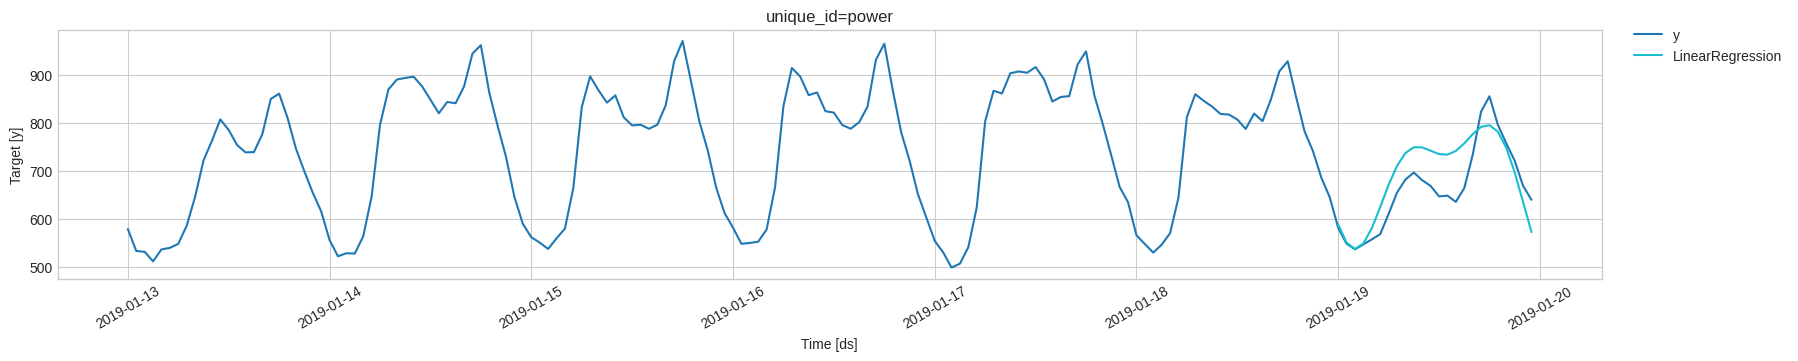

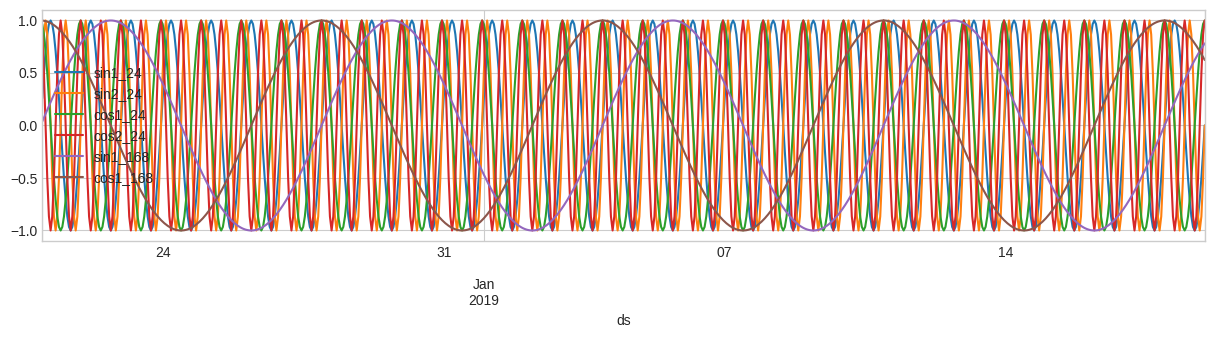

In [8]:
# Step 1: Define Fourier features
features = [
    partial(fourier, season_length=24, k=2),
    partial(fourier, season_length=24*7, k=1)
]

# Step 2: Run the pipeline to create training and future features
# df must contain columns: ['unique_id', 'ds', 'y']
train_df, future_df = pipeline(
    df_nixtla.iloc[-24*30:-24],
    features=features,
    freq='1h',
    h= 24
    )

train_df[[c for c in train_df.columns if 'y' not in c]].plot(x='ds', figsize=(15, 3))

sf = MLForecast(
    models=[LinearRegression()],
    freq='1h',
    lags=[1]
)

sf = sf.fit(train_df, static_features=[])

predictions = sf.predict(h=24, X_df=future_df)
plot_series(df_nixtla.tail(24*7), predictions)

In [9]:
#@title Interactive Fourier model

import ipywidgets as widgets
from IPython.display import display



def fourier_interactive(df_nixtla, p_1 = 24, p_2 = 24 * 7):
  # Create dropdown to toggle order
  k1_slider = widgets.IntSlider(value=1, min=1, max=50, step=1, description='k1 (daily)', continuous_update=False)
  k2_slider = widgets.IntSlider(value=1, min=1, max=50, step=1, description='k2 (weekly)', continuous_update=False)


  def update_plot(k1, k2):

        features = [
            partial(fourier, season_length=p_2, k=k2),       # weekly
            partial(fourier, season_length=p_1, k=k1),         # daily
        ]
        # Step 2: Run the pipeline to create training and future features
        # df must contain columns: ['unique_id', 'ds', 'y']
        train_df, future_df = pipeline(
            df_nixtla.tail(p_1+p_2)[:-p_1],
            features=features,
            freq='1h',
            h= p_1
        )


        sf = MLForecast(
            models=[LinearRegression(fit_intercept=True)],
            freq='1h',
            lags=[1]
        )

        sf = sf.fit(train_df, static_features=[])

        predictions = sf.predict(h=p_1, X_df=future_df)
        predictions = predictions.rename(columns={'LinearRegression': 'y'})
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        df_nixtla.tail(p_1 + p_2).plot(x='ds', y='y', ax=ax)
        predictions.plot(x='ds', y='y', ax=ax)
        # plot ground truth

        plt.show()

  # Link widget to function
  ui = widgets.VBox([k1_slider, k2_slider])
  out = widgets.interactive_output(update_plot, {'k1': k1_slider, 'k2': k2_slider})

  return display(ui, out)

fourier_interactive(df_nixtla)

Output()

# Regression via embeddings - direct approach
<img src="https://github.com/nepslor/B5203E-TSAF/raw/95ab6491476169ca761b47d1bee8735b12346694/pics/direct_forecast.png" width="600">

We've seen how to craft a Fourier forecaster, by using sine and cosine basis functions defined over time. This is a linear regression problem, but at the end what's happening is that *we are copy-pasting a low fidelity (or smoothed) representation of the signal*.

A more general approach is the linear regression via **embeddings**.

Let's say we want to forecast $m_f$ steps in the future using the last $m_p$ lags. We can then define a dataset of delayed vectors.
\begin{align}
E(m_p  + m_f) &= [Y_p, Y_f]\\
=&\begin{bmatrix}
\color{darkred}{y(0)}       & \color{darkred}{y(1)}   & \color{darkred}{\cdots y(m_p)}    & \color{darkblue}{y(m_p + 1)}       & \color{darkblue}{\cdots} & \color{darkblue}{y(m_p+m_f)} \\
\color{darkred}{y(1)}       & \color{darkred}{y(2)}   & \color{darkred}{\cdots y(m_p + 1)} & \color{darkblue}{y(m_p + 2)}    & \color{darkblue}{\cdots} & \color{darkblue}{y(m_p+m_f+1)} \\
\color{darkred}{y(2)}       & \color{darkred}{y(3)}   & \color{darkred}{\cdots y(m_p + 2)} & \color{darkblue}{y(m_p + 3)}    & \color{darkblue}{\cdots} & \color{darkblue}{y(m_p+m_f+2)} \\
\color{darkred}{\vdots}     & \color{darkred}{\vdots} & \color{darkred}{\vdots}            & \color{darkblue}{\vdots}         & \color{darkblue}{\ddots} & \color{darkblue}{\vdots} \\
\color{darkred}{y(T-m_p-m_f)} & \color{darkred}{y(T-m_p-m_f-1)} & \color{darkred}{\cdots} & \color{darkblue}{\cdots} & \color{darkblue}{\cdots} & \color{darkblue}{y(T)}
\end{bmatrix}
\end{align}
you can see each row as independent instances, in which the red columns are features and the blue ones are targets.

The forecasting task is now turned into a regression problem, in which we train the parameters $\beta$ of a regressor $f_{\beta}$:
$$ \min_{\beta} \Vert f_{\beta}(Y_p) -Y_f \Vert_2$$

When the regressor $f$ is a linear model, the optimal values of $\beta$ can be written as before:
$$\beta^* = (Y_p^TY_p)^{-1}(Y_p^TY_f)$$


# ❓ Define an embedding function, returning $E$.
The function takes as input the pd.Series s and the maximum number of lags m. Create m lags and stack them together to create teh embedding matrix $E$. Beware! We'll introduce some NaNs in the process, you can drop rows with nans using `dropna`

In [10]:
def embedding(s, m):
  e = pd.concat([s.copy().shift(-i).rename('{}_{:02d}'.format(s.name, i)) for i in range(1, m+1)], axis=1)
  e.dropna(inplace=True)
  return e

embedding(df_power['power'], 10)


power_01    power_02    power_03    power_04  \
2018-01-13 00:00:00+00:00 -220.849827 -240.195549 -233.736994 -221.069105   
2018-01-13 01:00:00+00:00 -240.195549 -233.736994 -221.069105 -206.164327   
2018-01-13 02:00:00+00:00 -233.736994 -221.069105 -206.164327 -173.887161   
2018-01-13 03:00:00+00:00 -221.069105 -206.164327 -173.887161 -127.154772   
2018-01-13 04:00:00+00:00 -206.164327 -173.887161 -127.154772  -89.669994   
...                               ...         ...         ...         ...   
2019-01-19 09:00:00+00:00  680.777556  668.823056  647.004167  648.524000   
2019-01-19 10:00:00+00:00  668.823056  647.004167  648.524000  635.531500   
2019-01-19 11:00:00+00:00  647.004167  648.524000  635.531500  664.147444   
2019-01-19 12:00:00+00:00  648.524000  635.531500  664.147444  733.269889   
2019-01-19 13:00:00+00:00  635.531500  664.147444  733.269889  824.033833   

                             power_05    power_06    power_07    power_08  \
2018-01-13 00:00:00+00:00 -206.164327 -173.887161 -127.154772  -89.669994   
2018-01-13 01:00:00+00:00 -173.887161 -127.154772  -89.669994  -96.810272   
2018-01-13 02:00:00+00:00 -127.154772  -89.669994  -96.810272  -98.539883   
2018-01-13 03:00:00+00:00  -89.669994  -96.810272  -98.539883  -95.994049   
2018-01-13 04:00:00+00:00  -96.810272  -98.539883  -95.994049  -96.726549   
...                               ...         ...         ...         ...   
2019-01-19 09:00:00+00:00  635.531500  664.147444  733.269889  824.033833   
2019-01-19 10:00:00+00:00  664.147444  733.269889  824.033833  856.190611   
2019-01-19 11:00:00+00:00  733.269889  824.033833  856.190611  796.612389   
2019-01-19 12:00:00+00:00  824.033833  856.190611  796.612389  757.770556   
2019-01-19 13:00:00+00:00  856.190611  796.612389  757.770556  721.653722   

                             power_09    power_10  
2018-01-13 00:00:00+00:00  -96.810272  -98.539883  
2018-01-13 01:00:00+00:00  -98.539883  -95.994049  
2018-01-13 02:00:00+00:00  -95.994049  -96.726549  
2018-01-13 03:00:00+00:00  -96.726549 -117.206383  
2018-01-13 04:00:00+00:00 -117.206383 -111.352883  
...                               ...         ...  
2019-01-19 09:00:00+00:00  856.190611  796.612389  
2019-01-19 10:00:00+00:00  796.612389  757.770556  
2019-01-19 11:00:00+00:00  757.770556  721.653722  
2019-01-19 12:00:00+00:00  721.653722  669.020611  
2019-01-19 13:00:00+00:00  669.020611  639.883889  

[8918 rows x 10 columns]

# ❓ Complete the linear direct forecaster
The forecaster retrieve the embedding and perform a training, test split. Complete the fit procedure:

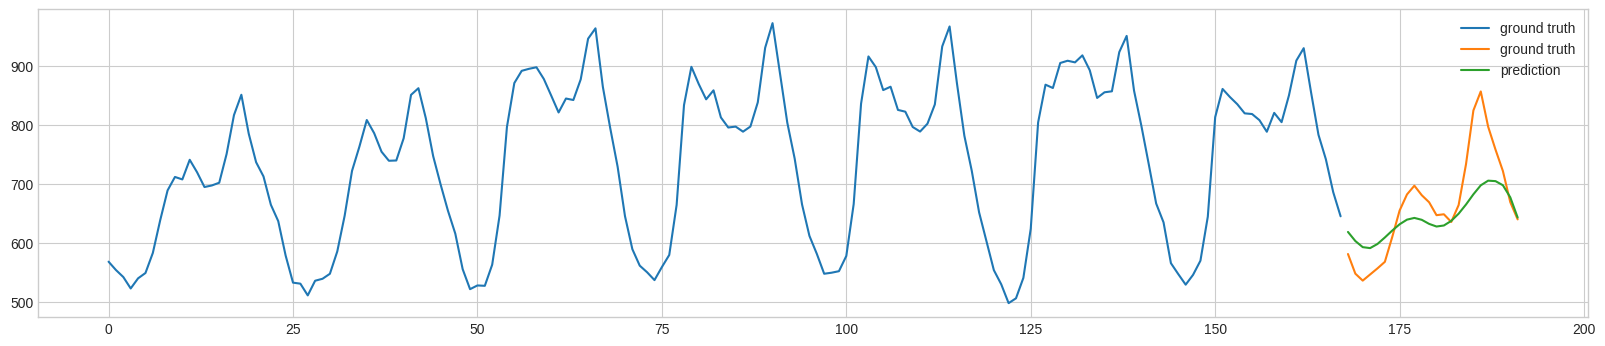

In [11]:
m_p = 2
m_f = 24

def linear_forecaster(df, m_p, m_f):
  e = embedding(df, m_p+m_f)
  y_p_tr, y_f_tr = e.iloc[:-1, :m_p], e.iloc[:-1, m_p:m_f+m_p]
  y_p_te, y_f_te = e.iloc[[-1], :m_p], e.iloc[[-1], m_p:m_f+m_p]

  beta = np.linalg.inv(y_p_tr.T@y_p_tr)@y_p_tr.T@y_f_tr
  y_hat = y_p_te@beta.values
  return y_f_te, y_hat

y_f_te, y_hat = linear_forecaster(df_power['power'], m_p, m_f)
# plot y_f_te and predictions
plt.subplots(1, 1, figsize=(20, 4))
plt.plot(df_power['power'].iloc[-24*8:-24].values.ravel(), label='ground truth')
plt.plot(range(24*7, 24*7 + m_f), y_f_te.values.ravel(), label='ground truth')
plt.plot(range(24*7, 24*7 + m_f), y_hat.values.ravel(), label='prediction')
plt.legend();


In [12]:

def regression_interactive(df, m_p = 24, m_f = 24 * 7, plot_steps=24*8):
  # Create dropdown to toggle order
  k1_slider = widgets.IntSlider(value=2, min=2, max=1500, step=1, description='m_p', continuous_update=False)
  k2_slider = widgets.IntSlider(value=24, min=3, max=1000, step=1, description='m_f', continuous_update=False)


  def update_plot(m_p, m_f):
    _, y_hat = linear_forecaster(df, m_p, m_f)
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    plt.plot(df.tail(plot_steps).values.ravel(), label='ground truth')
    plt.plot(range(plot_steps-m_f, plot_steps), y_hat.values.ravel(), label='prediction')
    plt.legend()
    plt.show()

  # Link widget to function
  ui = widgets.VBox([k1_slider, k2_slider])
  out = widgets.interactive_output(update_plot, {'m_p': k1_slider, 'm_f': k2_slider})

  return display(ui, out)

regression_interactive(df_power['power'])

Output()

# Regression via embeddings - recursive approach
With Nixtla it's possible to implement a recursive forecasting strategy.
<img src="https://github.com/nepslor/B5203E-TSAF/raw/95ab6491476169ca761b47d1bee8735b12346694/pics/recursive_forecast.png" width="600">


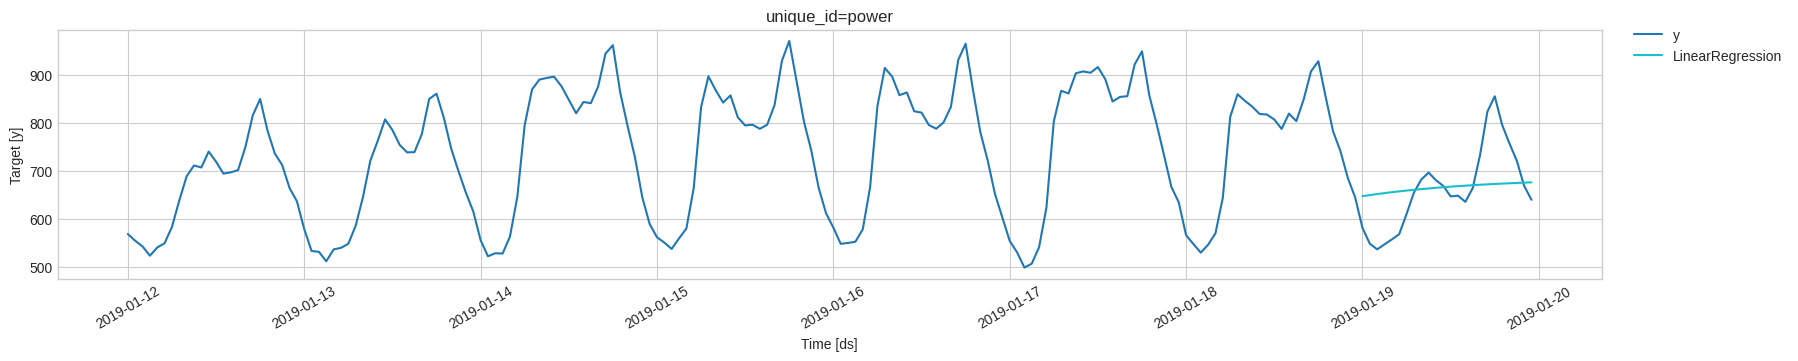

In [13]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

fcst = MLForecast(models=[LinearRegression()],
                   freq='1h',
                   lags=[1])

fcst.fit(df_nixtla.iloc[-24*30:-24])
predictions = fcst.predict(h=24)
plot_series(df_nixtla.tail(24*8), predictions)

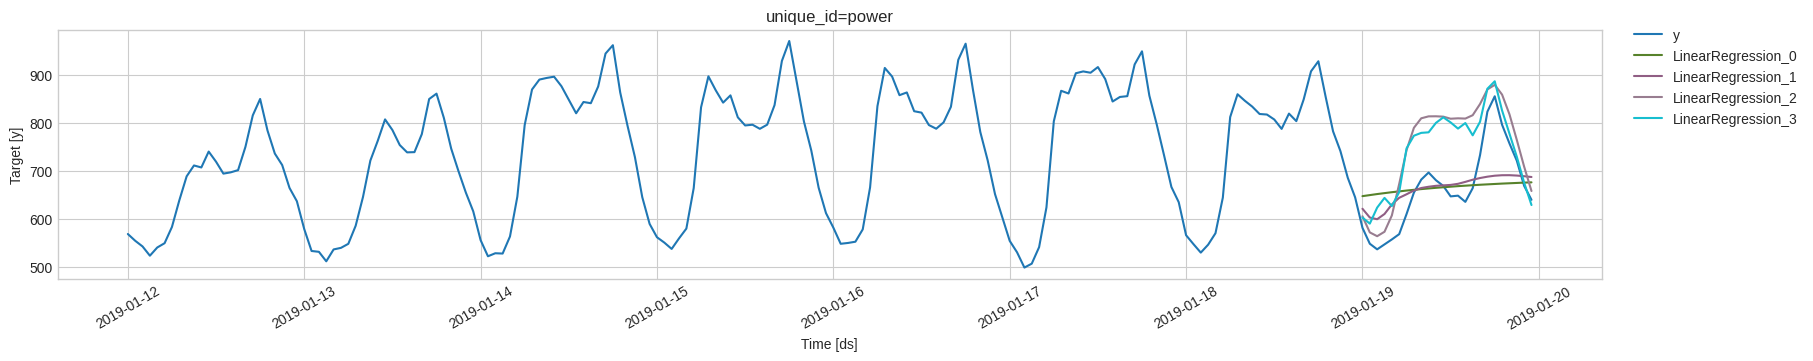

In [14]:
# we define a set of 5 forecasts, each of which is a linear model using
# increasing lags of the target as features
fcst = [MLForecast(models=[LinearRegression()],
                   freq='1h',
                   lags=list(range(1, i)))
        for i in [2, 12, 24, 24*7]]

[f.fit(df_nixtla.iloc[-24*30:-24]) for f in fcst];
predictions = [f.predict(h=24) for f in fcst]

# we stack the predictions together renaming them
joined_predictions = []

for i, prediction_df in enumerate(predictions):
    prediction_df = prediction_df.rename(columns={'LinearRegression': f'LinearRegression_{i}'})
    if i == 0:
        joined_predictions = prediction_df
    else:
        joined_predictions = pd.merge(joined_predictions, prediction_df, on=['unique_id', 'ds'], how='outer')

plot_series(df_nixtla.tail(24*8), joined_predictions)

# Pitfalls of Fourier forecast
Fourier forecasting isn't a great choice when we are dealing with nonstationary, non periodic data.
The following ECG data is a good example. These timeseries show repeating patterns but are not exactly cyclical.

In [15]:
df_ecg = pd.read_pickle('https://github.com/nepslor/teaching/raw/refs/heads/main/TimeSeriesForecasting/data/ecg_dat.pkl')

We'll try to forecast the first signal

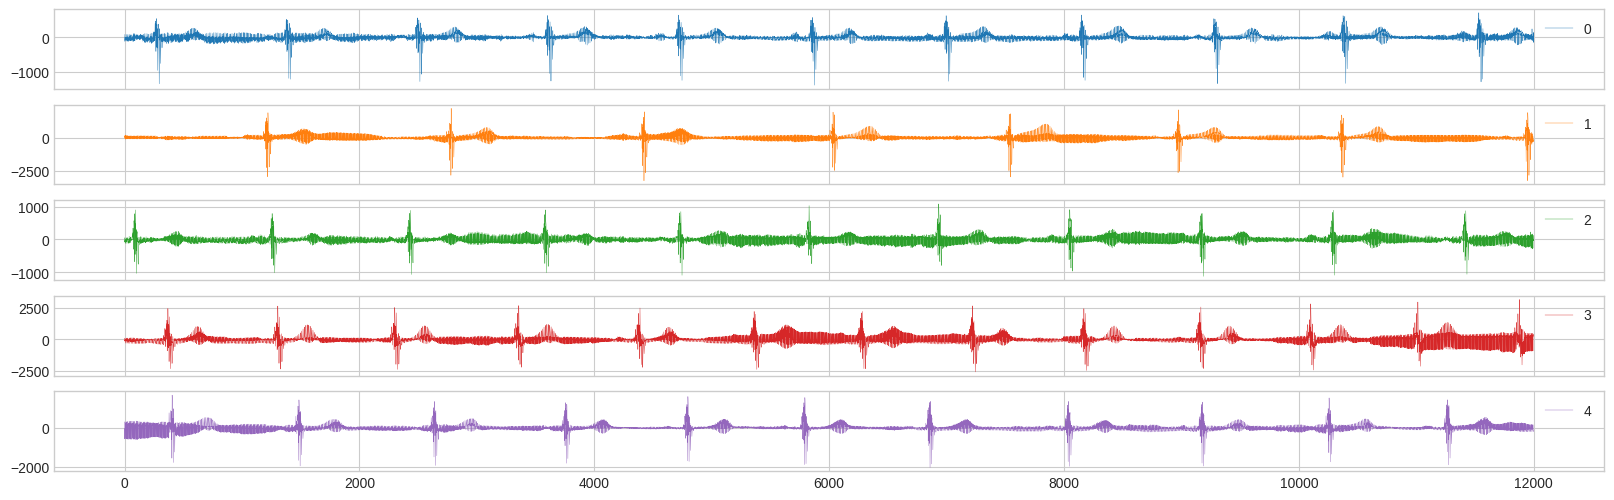

In [16]:
df_ecg.iloc[:, :5].plot(subplots=True, figsize=(20, 6), linewidth=0.3);

In [17]:
df_ecg.index = pd.date_range(start='2024-01-01', freq='1h', periods=len(df_ecg))

In [18]:
df_nixtla = convert_to_nixtla_ts(df_ecg.iloc[:, 0].astype(float))
fourier_interactive(df_nixtla, 400, 1200)

Output()

In [19]:
regression_interactive(df_ecg.iloc[:, 0].astype(float), 1000, 1000, 1200)

Output()

In [20]:
import numpy as np, pandas as pd, statsmodels.api as sm
import plotly.graph_objects as go
# Use your df_ecg if present; else make a tiny synthetic DF so this cell always works
try:
    df_ecg
except NameError:
    t = np.linspace(0, 20, 5000)
    rng = np.random.default_rng(0)
    df_ecg = pd.DataFrame({f"S{i}": np.sin(2*np.pi*(1+i*0.2)*t)+0.2*rng.standard_normal(t.size) for i in range(5)})

def compute_acf(y, max_lags=2000):
    y = np.asarray(y, float)
    nlags = min(max_lags, len(y)-1)
    acf_vals = sm.tsa.acf(y, nlags=nlags, fft=True)
    lags = np.arange(acf_vals.size)
    conf = 1.96 / np.sqrt(len(y))
    return acf_vals, lags, conf

idx0 = 0
y0 = df_ecg.iloc[:, idx0].values
acf0, lags0, conf0 = compute_acf(y0)

fig_acf = go.FigureWidget([
    go.Scatter(x=lags0, y=acf0, mode='lines+markers', marker=dict(size=4), line=dict(width=1),
               name=f'ACF for {df_ecg.columns[idx0]}')
])
fig_acf.update_layout(
    title=f'ACF for {df_ecg.columns[idx0]}',
    xaxis_title='Lags', yaxis_title='Autocorrelation',
    hovermode='closest', margin=dict(l=0, r=0, t=40, b=0),
    shapes=[
        dict(type='line', xref='x', yref='y', x0=0, y0= conf0, x1=int(lags0[-1]), y1= conf0, line=dict(width=1, dash='dash')),
        dict(type='line', xref='x', yref='y', x0=0, y0=-conf0, x1=int(lags0[-1]), y1=-conf0, line=dict(width=1, dash='dash')),
    ]
)

sig_slider = widgets.IntSlider(min=0, max=df_ecg.shape[1]-1, value=idx0, description='Signal', continuous_update=False)

def on_sig(change):
    if change["name"] != "value": return
    idx = int(change["new"])
    y = df_ecg.iloc[:, idx].values
    acf_vals, lags, conf = compute_acf(y)
    with fig_acf.batch_update():
        fig_acf.data[0].x = lags
        fig_acf.data[0].y = acf_vals
        fig_acf.data[0].name = f'ACF for {df_ecg.columns[idx]}'
        fig_acf.layout.title = f'ACF for {df_ecg.columns[idx]}'
        fig_acf.layout.shapes = [
            dict(type='line', xref='x', yref='y', x0=0, y0= conf, x1=int(lags[-1]), y1= conf, line=dict(width=1, dash='dash')),
            dict(type='line', xref='x', yref='y', x0=0, y0=-conf, x1=int(lags[-1]), y1=-conf, line=dict(width=1, dash='dash')),
        ]

sig_slider.observe(on_sig, names="value")
display(widgets.VBox([sig_slider, fig_acf]))

    '…

In [21]:

def create_embedding(data, tau, d):
    m = tau * d
    emb = embedding(data, m)
    emb = emb.values[:, ::tau]
    return emb


ecg_signal = df_ecg.iloc[:, 0]
tau0, d0 = 10, 3
emb0 = create_embedding(ecg_signal, tau0, max(d0,3))
x0, y0, z0 = emb0[:,0], emb0[:,1], emb0[:,2]

fig_ph = go.FigureWidget([
    go.Scatter3d(x=x0, y=y0, z=z0, mode='lines+markers', marker=dict(size=2), line=dict(width=1))
])
fig_ph.update_layout(
    title=f'Phase Reconstruction (tau={tau0}, d={d0})',
    margin=dict(l=0, r=0, t=40, b=0),
    scene=dict(aspectmode='data', xaxis_title='y(t)', yaxis_title=f'y(t+{tau0})', zaxis_title=f'y(t+{2*tau0})')
)

tau_slider = widgets.IntSlider(min=1, max=24, step=1, value=tau0, description='tau', continuous_update=False)
d_slider   = widgets.IntSlider(min=1, max=10,  step=1, value=d0,   description='d',   continuous_update=False)

def update(_=None):
    tau, d = tau_slider.value, d_slider.value
    emb = create_embedding(ecg_signal, tau, max(d,3))
    with fig_ph.batch_update():
        if emb.size == 0:
            fig_ph.data[0].x = []; fig_ph.data[0].y = []; fig_ph.data[0].z = []
            fig_ph.layout.title = f"Embedding too large (tau={tau}, d={d})"
            return
        if d >= 3:
            x, y, z = emb[:,0], emb[:,1], emb[:,2]
            fig_ph.layout.scene.xaxis.title = "y(t)"
            fig_ph.layout.scene.yaxis.title = f"y(t+{tau})"
            fig_ph.layout.scene.zaxis.title = f"y(t+{2*tau})"
        elif d == 2:
            x, y, z = emb[:,0], emb[:,1], np.zeros(len(emb))
            fig_ph.layout.scene.xaxis.title = "y(t)"
            fig_ph.layout.scene.yaxis.title = f"y(t+{tau})"
            fig_ph.layout.scene.zaxis.title = "0"
        else:  # d==1
            idx = np.arange(emb.shape[0])
            x, y, z = idx, emb[:,0], np.zeros(len(emb))
            fig_ph.layout.scene.xaxis.title = "t"
            fig_ph.layout.scene.yaxis.title = "y(t)"
            fig_ph.layout.scene.zaxis.title = "0"
        fig_ph.data[0].x, fig_ph.data[0].y, fig_ph.data[0].z = x, y, z
        fig_ph.layout.title = f'Phase Reconstruction (tau={tau}, d={d})'

tau_slider.observe(update, names='value')
d_slider.observe(update, names='value')
update()
display(widgets.VBox([widgets.HBox([tau_slider, d_slider]), fig_ph]))

In [32]:
import ipywidgets as widgets
from IPython.display import display

def linear_forecaster_emb(df, tau, d, m_f):
  m_p = tau * d
  e = embedding(df, m_p+m_f)
  y_p_tr, y_f_tr = e.iloc[:-1, :m_p], e.iloc[:-1, m_p:m_f+m_p]
  y_p_te, y_f_te = e.iloc[[-1], :m_p], e.iloc[[-1], m_p:m_f+m_p]
  y_p_tr = y_p_tr[:, ::tau]
  y_p_te = y_p_te[:, ::tau]
  beta = np.linalg.inv(y_p_tr.T@y_p_tr)@y_p_tr.T@y_f_tr
  y_hat = y_p_te@beta.values
  return y_f_te, y_hat

def regression_interactive(df, m_f = 24, plot_steps=24*8):
  # Create dropdown to toggle order
  k1_slider = widgets.IntSlider(value=2, min=2, max=36, step=1, description='tau', continuous_update=False)
  k2_slider = widgets.IntSlider(value=24, min=3, max=30, step=1, description='d', continuous_update=False)


  def update_plot(tau, d, m_f):
    _, y_hat = linear_forecaster_emb(df, tau, d, m_f)
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    plt.plot(df.tail(plot_steps).values.ravel(), label='ground truth')
    plt.plot(range(plot_steps-m_f, plot_steps), y_hat.values.ravel(), label='prediction')
    plt.legend()
    plt.show()

  # Link widget to function
  ui = widgets.VBox([k1_slider, k2_slider])
  out = widgets.interactive_output(update_plot, {'tau': k1_slider, 'd': k2_slider})

  return display(ui, out)

regression_interactive(df_power['power'])

Output()